# Hash
A hash is an fixed sized integer that identifies a particular value. Each value needs to have its own hash, so for the same value you will get the same hash even if it's not the same object. Furthermore hash of an integer is the same integer.
hash() is used for comparing objects. An object is deemed hashable if it can be compared to other objects. hash() is also used to access dict and set elements which are implemented as resizable hash tables in CPython.
Technically speaking:
* Usually comparing objects (which may involve several levels of recursion) is expensive.
* preferably, the hash() function is an order of magnitude (or several) less expensive.
* comparing two hashes is easier than comparing two objects, this is where the shortcut is.
* The python dict is a hashmap, its worst case is therefore O(n) if we have hash collision. However that is a very rare case where every item added has the same hash and so is added to the same chain. Hence, the average time complexity is still O(1). check [Time Complexity](http://wiki.python.org/moin/TimeComplexity) for more.
* An object is hashable if [1] it has a hash value which never changes during its lifetime (it needs a __hash__() method), and can be compared to other objects (it needs an __eq__() method). [2] Hashable objects which compare equal must have the same hash value.

```
>>> hash("Look at me!")
4343814758193556824
>>> f = "Look at me!"
>>> hash(f)
4343814758193556824
```
Hash values need to be created in such a way that the resulting values are evenly distributed to reduce the number of hash collisions you get. Hash collisions are when two different values have the same hash. Therefore, relatively small changes often result in very different hashes.
```
>>> hash("Look at me!!")
6941904779894686356
```
These numbers are very useful, as they enable quick look-up of values in a large collection of values. Two examples of their use are Python's `set` and `dict`. In a `list`, if you want to check if a value is in the list, with `if x in values:`, Python needs to go through the whole list and compare `x` with each value in the list values. This can take a long time for a long list. In a set, Python keeps track of each hash, and when you type `if x in values:`, Python will get the hash-value for `x`, look that up in an internal structure and then only compare `x` with the values that have the same hash as `x`.

The same methodology is used for dictionary lookup. **This makes lookup in set and dict very fast, while lookup in list is slow. It also means you can have non-hashable objects in a list, but not in a set or as keys in a dict.** The typical example of non-hashable objects is any object that is **mutable**, meaning that you can change its value. If you have a mutable object it should not be hashable, as its hash then will change over its life-time, which would cause a lot of confusion, as an object could end up under the wrong hash value in a dictionary.

Note that the hash of a value only needs to be the same for one run of Python. In Python 3.3 they will in fact change for every new run of Python:
```
$ /opt/python33/bin/python3
Python 3.3.2 (default, Jun 17 2013, 17:49:21) 
[GCC 4.6.3] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> hash("foo")
1849024199686380661
>>> 
$ /opt/python33/bin/python3
Python 3.3.2 (default, Jun 17 2013, 17:49:21) 
[GCC 4.6.3] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> hash("foo")
-7416743951976404299
```
This is to make it harder to guess what hash value a certain string will have, which is an important security feature for web applications etc.

### Why mutable object shouldn't be hashable:
the short answer is that if the object's value changes, then the hash must also change since hashes are based on values. However, if the object's value changes after it's used as a key in a dictionary, the hash will no longer refer to the correct bucket in the dictionary for that key. Let's use an example. Watch Brandon Rhode's PyCon 2010 talk [The Mighty Dictionary](https://www.youtube.com/watch?v=C4Kc8xzcA68) about how dictioneries work in python. Let's use an example.
```
>>> import collections

>>> class HashableList(collections.UserList):
...     def __hash__(self):
...         return hash(tuple(self))
```
We can create a hashable list object and put it in a dictionary:
```
>>> h = HashableList([1, 2, 3])

>>> d = {h: 'hello'}

>>> d
{[1, 2, 3]: 'hello'}
```
It seems to work. We even make another hashable list with the same value and it seems to work too:
```
>>> d[h]
'hello'

>>> h2 = HashableList([1, 2, 3])

>>> d[h2]
'hello'
```
Now we change h. 
```
>>> h[2] = 100

>>> d[h]
Traceback (most recent call last):
  File "stdin", line 1, in module
KeyError: [1, 2, 100]
```
The key in d isn't a copy of the [1, 2, 3] object, it's a copy of the reference. **When we changed h, we also changed the dictionary key:**
```
>>> d
{[1, 2, 100]: 'hello'}
```
So this means the key is now [1, 2, 100], but it's in the bucket/slot for [1, 2, 3]. **But here's the thing.** h2 no longer works as a key, even though it is [1, 2, 3].
```
>>> d[h2]
Traceback (most recent call last):
  File "stdin", line 1, in module
KeyError: [1, 2, 3]
```
h2's [1, 2, 3] won't work because the key's value is now [1, 2, 100] and Python just assumes it happens to be a hash collision.

### Learning by example:
Imagine we have this class:

```
>>> class Person(object):
...     def __init__(self, name, ssn, address):
...         self.name = name
...         self.ssn = ssn
...         self.address = address
...     def __hash__(self):
...         return hash(self.ssn)
...     def __eq__(self, other):
...         return self.ssn == other.ssn
... 
```
And we have Bob:
```
>>> bob = Person('bob', '1111-222-333', None)
```
bob goes to see a judge to change his name to jim:
```
>>> jim = Person('jim bo', '1111-222-333', 'sf bay area')
```
Both objects are compared based on the ssn hash and they are equal as expected:
```
>>> bob == jim
True
```
Note that these are two different objects with different memory allocated:
```
>>> bob is jim
False
```
Now comes the part where hash() is handy, using the value as a key to a dictionary:
```
>>> dmv_appointments = {}
>>> dmv_appointments[bob] = 'tomorrow'
```
jim and bob are two different objects with the same hash. If we use jim as a key to the same dictionary, it's hash value collides with bob's.
Python automatically calls the `__eq__` method of a class when you use the == operator to compare the instances of the class. By default, Python uses the `is` operator if you don't provide a specific implementation for the `__eq__` method.
```
>>> dmv_appointments[jim] #?
'tomorrow'
```
hash of a literal integer is the same as the integer value.
```
>>> hash(bob) == hash(hash(bob))
True
```
Now try this:
```
>>> dmv_appointments[hash(bob)]
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
  File "<stdin>", line 9, in __eq__
AttributeError: 'int' object has no attribute 'ssn'
>>> hash(bob) == hash(hash(bob))
True
```
If we use `hash(bob)` as a key to the dictionary, it's hash collides with bob's hash. Therefore, the `__equal__` methode of Person class is going to be called to check if `Bob==hash(bob)`. However, hash(bob) is not of Person class and does not have a ssn attribute to be used in 'Person.__equal__()' method. Therefore and Exception is raised.
One last test:
```
>>> del Person.__eq__
>>> dmv_appointments[bob]
'tomorrow'
>>> dmv_appointments[jim]
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyError: <__main__.Person object at 0x7f611bd37110>
```
There is a collision between hashes of bob and jim. Since there is no `__equal__()` method, python uses `is` method to compare the equality of those two objects.
```
>>> bob is jim
False
>>> bob == jim
False
```

# get all unique combinations of two Lists for a two level index

**permutations is changing the linear order of an ordered set**

In [143]:
import itertools 
from itertools import permutations 
long1 = ["a", "b", "c"] 
short2 = [1, 2]
unique_combinations = []

get all the permutation of the same length as the other list

In [144]:
# get all the r-length permutations of the iterable "long"
permut1 = itertools.permutations(iterable=long1, r=len(short2)) 
i = 0
for comb in permut1: 
    print(comb)
    i += 1
print(i)
# i= 3*2

('a', 'b')
('a', 'c')
('b', 'a')
('b', 'c')
('c', 'a')
('c', 'b')
6


In [145]:
# get all the r-length permutations of the iterable "long"
permut1 = itertools.permutations(iterable=long1, r=len(short2)) 
unique_combinations = []
for comb in permut1: 
    zipped = zip(comb, short2) 
    unique_combinations.append(list(zipped)) 
print(unique_combinations) 
# zip a shortedned permutation of a long list with an equal length ordered short list
print(len(unique_combinations)) #3*2

[[('a', 1), ('b', 2)], [('a', 1), ('c', 2)], [('b', 1), ('a', 2)], [('b', 1), ('c', 2)], [('c', 1), ('a', 2)], [('c', 1), ('b', 2)]]
6


### Method 2 itertools.product
Cartesian product of input iterables.  Equivalent to nested for-loops.
For example, product(A, B) returns the same as:  ((x,y) for x in A for y in B)

In [146]:
import itertools 
from itertools import product
long1 = ["a", "b", "c"] 
short2 = [1, 2]

In [147]:
i = 0
# Cartesian product of input iterables.  Equivalent to nested for-loops.
# product(A, repeat=4) means the same as product(A, A, A, A)
prod = product(short2, repeat = len(long1))
for comb in prod:
    print(comb)
    i += 1
print(i)
# i =2**3

(1, 1, 1)
(1, 1, 2)
(1, 2, 1)
(1, 2, 2)
(2, 1, 1)
(2, 1, 2)
(2, 2, 1)
(2, 2, 2)
8


In [148]:
unique_combinations = [] 
prod = product(short2, repeat = len(long1))
unique_combinations = list(list(zip(long1, element)) 
                           for element in prod) 
  
print(unique_combinations)
print(len(unique_combinations)) #2**3

[[('a', 1), ('b', 1), ('c', 1)], [('a', 1), ('b', 1), ('c', 2)], [('a', 1), ('b', 2), ('c', 1)], [('a', 1), ('b', 2), ('c', 2)], [('a', 2), ('b', 1), ('c', 1)], [('a', 2), ('b', 1), ('c', 2)], [('a', 2), ('b', 2), ('c', 1)], [('a', 2), ('b', 2), ('c', 2)]]
8


In [149]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.3.1/en_core_web_md-2.3.1.tar.gz

In colab we need to import the spacy en_core_web_md as a package with !pip install instead of python install on the terminal. After that we need to restart the runtime.

In [150]:
import os
import pickle

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

*Upload subreddit_db.sqlite3 database*


In [151]:
# from google.colab import files 
# uploaded = files.upload()

In [152]:
import pandas as pd
import sqlite3
import numpy as np

def refresh_connection_and_cursor():
    try:
        c.close()
        conn.close()
    except: pass
  
#     conn = sqlite3.connect('./submission_db.sqlite3')
    conn = sqlite3.connect('./subreddit_db.sqlite3')

    c = conn.cursor()
    return conn, c

conn, c = refresh_connection_and_cursor()

data = pd.read_sql_query("select * from submission_table order by random() limit 100000;", conn)

c.close()
conn.close()

In [153]:
# subreddit_subs: is the number of subscriber in the subreddit category
print(data.shape)
data.head()

(51610, 4)


,subreddit_name,subreddit_id,title,text
0,literature,2qhps,James Franco's poems: hard to forgive,
1,technology,2qh16,Predator Drone Spotted in Minneapolis During G...,
2,DIY,2qh7d,I restored a $5 Kitchen Aid mixer I found at t...,
3,news,2qh3l,Alabama just passed a near-total abortion ban ...,
4,Parenting,2qhn3,I thought my 6 year old was doing one of his m...,My 6 year old has a bunch of new apps and acti...


In [155]:
import re
htm1 = pd.DataFrame.to_html(data.head())
# remove spaces
html = re.sub('>\s*<', '><', html)
# add scroll
style="overflow-x: scroll;display: block; max-height: 300px;
html = re.sub('class="dataframe"', 'class="dataframe" style="overflow-x: scroll;display: block; max-height: 500px;"', html)
# write html to file 
text_file = open("index.html", "w") 
text_file.write(html) 
text_file.close() 

SyntaxError: EOL while scanning string literal (<ipython-input-155-9020d874e1cb>, line 6)

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20368 entries, 0 to 51609
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subreddit_name  20368 non-null  object
 1   subreddit_id    20368 non-null  object
 2   title           20368 non-null  object
 3   text            20368 non-null  object
 4   joint_text      20368 non-null  object
dtypes: object(5)
memory usage: 954.8+ KB


In [14]:
# There are 200 subreddit categories
subreddit_names = data['subreddit_name'].unique()
len(subreddit_names), subreddit_names

(53,
 array(['LifeProTips', 'movies', 'nottheonion', 'history', 'AdviceAnimals',
        'scifi', 'personalfinance', 'funny', 'AskReddit', 'Parenting',
        'literature', 'DIY', 'politics', 'WTF', 'Art', 'mildlyinteresting',
        'programming', 'MachineLearning', 'space', 'news', 'technology',
        'Coronavirus', 'socialskills', 'worldpolitics', 'Fitness',
        'Cooking', 'Music', 'sports', 'HomeImprovement', 'Health', 'books',
        'worldnews', 'PublicFreakout', 'math', 'camping', 'gadgets',
        'science', 'Documentaries', 'biology', 'entertainment', 'cars',
        'food', 'gaming', 'GetMotivated', 'television', 'travel', 'Design',
        'JusticeServed', 'investing', 'Showerthoughts', 'TwoXChromosomes',
        'conspiracy', 'announcements'], dtype=object))

### Data Wrangling

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
data[['subreddit_id', 'subreddit_name']].head(1)

,subreddit_id,subreddit_name
0,2s5oq,LifeProTips


In [18]:
# number of tweets per subreddit category
data['subreddit_id'].value_counts().tail(10)

2x4yx    985
2yrq6    983
2vxxc    983
2fwo     983
2qh87    983
2s5oq    970
2qnts    967
2szyo    962
2rmfx    932
2r0ij    160
Name: subreddit_id, dtype: int64

In [19]:
# number of subreddit categories
data['subreddit_id'].nunique()

53

#### pd.groupby() method:
groupby creates a dataframe group for each value of the new index that the grouping is based on. The iterator method iterates through the new index value and the dataframe groups.

**Iterating in a for loop and printing the iterated index values and each of the dataframe groups**

In [20]:
grouped = data[data.columns[:3]][1500:1510].groupby(by='subreddit_id')
i = 0
for index, row in grouped:
    print("index:", index)
    print(row)
    i +=1
    print("-----------", i, "------------------")

index: 2fwo
     subreddit_name subreddit_id                                         title
1500    programming         2fwo  Stop building websites with infinite scroll!
----------- 1 ------------------
index: 2qh0n
     subreddit_name subreddit_id  \
1505           math        2qh0n   

                                                  title  
1505  What is your favorite funny quote by a famous ...  
----------- 2 ------------------
index: 2qh1u
     subreddit_name subreddit_id  \
1502          Music        2qh1u   

                                                  title  
1502  Why do so many pop songs today include a rap v...  
----------- 3 ------------------
index: 2qhhq
     subreddit_name subreddit_id                                        title
1507      investing        2qhhq  Trading halted immediately upon market open
----------- 4 ------------------
index: 2qhn7
     subreddit_name subreddit_id  \
1508        biology        2qhn7   

                                       

**Alternative to using a loop to iterate over a DataFrameGroupby object is to use the pandas .apply() method.**

In [21]:
grouped.apply(lambda a: pd.concat([a,pd.DataFrame(
    [["-----"]*3], index = ["--"], columns=["subreddit_id", "subreddit_name", "subreddit_subs"])]))

subreddit_name subreddit_id  \
subreddit_id                                    
2fwo         1500    programming         2fwo   
             --            -----        -----   
2qh0n        1505           math        2qh0n   
             --            -----        -----   
2qh1u        1502          Music        2qh1u   
             --            -----        -----   
2qhhq        1507      investing        2qhhq   
             --            -----        -----   
2qhn7        1508        biology        2qhn7   
             --            -----        -----   
2qk80        1506        camping        2qk80   
             --            -----        -----   
2qnts        1503    nottheonion        2qnts   
             --            -----        -----   
2s5oq        1504    LifeProTips        2s5oq   
             --            -----        -----   
2s7tt        1509  AdviceAnimals        2s7tt   
             --            -----        -----   
mouw         1501        science         mouw   
             --            -----        -----   

                                                               title  \
subreddit_id                                                           
2fwo         1500       Stop building websites with infinite scroll!   
             --                                                  NaN   
2qh0n        1505  What is your favorite funny quote by a famous ...   
             --                                                  NaN   
2qh1u        1502  Why do so many pop songs today include a rap v...   
             --                                                  NaN   
2qhhq        1507        Trading halted immediately upon market open   
             --                                                  NaN   
2qhn7        1508  In Three Months, US Measles Cases Surpass 2018...   
             --                                                  NaN   
2qk80        1506  My very first solo camping trip: Abraham Lake,...   
             --                                                  NaN   
2qnts        1503  Robotic dildo barred from top tech showcase, p...   
             --                                                  NaN   
2s5oq        1504  LPT: if you are feeling depressed or you are i...   
             --                                                  NaN   
2s7tt        1509         No idea how I managed to get to work today   
             --                                                  NaN   
mouw         1501  A new study found that 44 percent of medical c...   
             --                                                  NaN   

                  subreddit_subs  
subreddit_id                      
2fwo         1500            NaN  
             --            -----  
2qh0n        1505            NaN  
             --            -----  
2qh1u        1502            NaN  
             --            -----  
2qhhq        1507            NaN  
             --            -----  
2qhn7        1508            NaN  
             --            -----  
2qk80        1506            NaN  
             --            -----  
2qnts        1503            NaN  
             --            -----  
2s5oq        1504            NaN  
             --            -----  
2s7tt        1509            NaN  
             --            -----  
mouw         1501            NaN  
             --            -----

**groupby create a multilevel index. Below code iterates over dataframe groups and grabs 'subreddit_name' column. Then by using .loc() method we slice both index levels on the 0 axis and return it on the output display**

In [22]:
list1 = ["2cneq", "2r2jt", "3icow"]
idx_lst = []
for lv1 in list1:
    for lv2 in range(1270,4000,1):
        idx_lst.append((lv1, lv2))
idx_lst[-5:]

[('3icow', 3995),
 ('3icow', 3996),
 ('3icow', 3997),
 ('3icow', 3998),
 ('3icow', 3999)]

In [23]:
"""
subreddit_id has become an index identifying each group.
'subreddit_name' is the values to perform group value_counts on.
"""
data.groupby(by='subreddit_id').apply(lambda a: a['subreddit_name']).value_counts().sample(10)

news                992
space               983
conspiracy          991
Music               988
nottheonion         967
camping             993
Art                1000
worldpolitics       995
personalfinance     989
books               993
Name: subreddit_name, dtype: int64

* Filter out subreddit_id with low number of posts

In [24]:
# filters group as subreddit_name similar to subreddit_id is the group identifier.
data.groupby(by='subreddit_id').filter(func=(lambda x: (x['subreddit_name'].value_counts() > 200))).shape

(51450, 4)

* Alternative approach

In [25]:
a=data['subreddit_id'].value_counts()>200
# b is the subreddit_id that has met the condition
b = a.index[a].copy()
# c is the boolean values corresponding to the indices based on the conition
c = data["subreddit_id"].isin(b)

data[c].shape

(51450, 4)

Alternative way to show the same thing

#### pd.agg() method:

In [26]:
data[['title', 'text']][4:5]

,title,text
4,Here's hoping...,


In [27]:
data[['title', 'text']][4:5].agg(lambda a: a[:])

,title,text
4,Here's hoping...,


In [28]:
def wrangle(data, text_len_min=100, subreddit_num=50):
    """
    data: dataframe containg the subreddits and their categories
    text_len_min: minimum length of subreddit text required to be analyzed
    statistical trimming:
    subreddit_num: sampled number of subreddit posts in each category
    """
    print("\n original data shape: ", data.shape)

    # converting the title and text columns to string type
    data[['title', 'text']] = data[['title', 'text']].astype('str')
    
    # Pandas Series.agg() is used to pass a function or list of function to be 
    # applied on a series or even each element of series separately.
    # merge title and text. ' '.join is a function
    data['joint_text'] = data[['title', 'text']].agg(' '.join, axis=1)

    # filter out non word and non space characters.
    # lower case the text and remove extra spaces
    data['joint_text'] = data['joint_text'].str.replace(
        "[^\w\s']",' ').str.lower().apply(
        lambda row: ' '.join(row.split()))
    
    # filter out the rows with no significant subreddit text
    data = data[[len(i)>text_len_min for i in data['joint_text']]]
    print(f"\n data shape after filter of length > {text_len_min}:")
    print(data.shape)

    # Plot the frequency of subreddit_id in the data set
    subid_count = data['subreddit_id'].value_counts(ascending=False)
    plt.figure(figsize=(12,5))
    # y axis is density plot
    # y is the count of subreddit categories with a certain mumber
    # of redit posts as ignified on x axis.
    sns.distplot(a=subid_count, kde=False)
    plt.title('''# of subreddit categories for bins of "# of posts
    \nafter filtering out short posts''')
    plt.xlabel('bin of # of posts')
    plt.ylabel("# of subreddit categories for bins of posts counts")

    """
    pandas.core.groupby.DataFrameGroupBy.filter(func=)
    Return a copy of a DataFrame excluding elements from groups 
    that do not satisfy the boolean criterion specified by func.
    func: Function to apply to each subframe(dataframe group). Should return True or False.
    
    don't confuse this with dataframe.filter(items=)
    """
    # filter out the subreddit_ids with low count of posts
    data = data.groupby(by='subreddit_id').filter(
        lambda x: (x['subreddit_id'].value_counts() > subreddit_num))
    print(f"\ndata shape after dropping low counts subreddit names: {subreddit_num}")
    print(data.shape)


    # Sample a fixed number of posts from each category
    df = data.groupby(by='subreddit_id', as_index=False).apply(
        lambda x: x.sample(n=subreddit_num, replace=False, random_state=1)).reset_index(
        level=0, drop=True)
    print(f"\ndf shape after sampling {subreddit_num} posts per subreddit category")
    print(df.shape)

    # Number of subreddit categories to classify on
    print(f"\n# of subreddit categories: {len(df['subreddit_id'].value_counts())}")

    return data, df


 original data shape:  (51610, 4)

 data shape after filter of length > 100:
(20918, 5)

data shape after dropping low counts subreddit names: 100
(20368, 5)

df shape after sampling 100 posts per subreddit category
(4400, 5)

# of subreddit categories: 44


/Users/gholami/anaconda3/envs/SubReddit/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


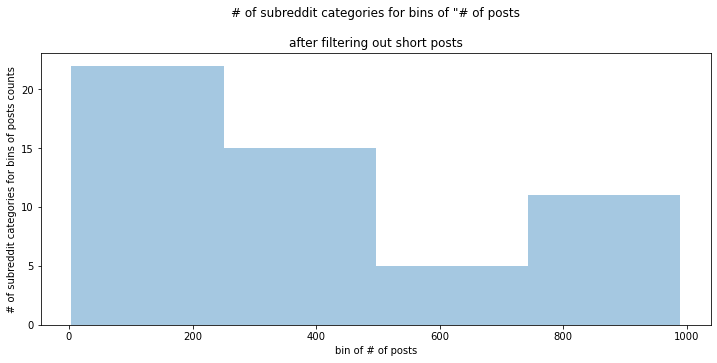

In [29]:
data, df = wrangle(data, text_len_min=100, subreddit_num=100);

In [30]:
print(df.shape)
df.sample(n=5, axis=0)

(4400, 5)


,subreddit_name,subreddit_id,title,text,joint_text
10218,Coronavirus,2x4yx,Vitamin D levels appear to play role in COVID-...,,vitamin d levels appear to play role in covid ...
5469,personalfinance,2qstm,[Credit] Employee at Mattress Firm offered to ...,"Went shopping for mattresses, and the employee...",credit employee at mattress firm offered to ch...
44289,technology,2qh16,London police chief ‘completely comfortable’ u...,,london police chief completely comfortable usi...
24571,Parenting,2qhn3,Today I was mom-shamed at a department store a...,\nToday my youngest child and I had 3 hours to...,today i was mom shamed at a department store a...
41223,worldpolitics,2qh9a,Hey remember how America goes around murdering...,,hey remember how america goes around murdering...


In [31]:
df['subreddit_name'].unique()

array(['politics', 'programming', 'sports', 'gaming', 'entertainment',
       'math', 'worldnews', 'technology', 'AskReddit', 'Music', 'scifi',
       'news', 'movies', 'travel', 'books', 'conspiracy', 'history',
       'television', 'Design', 'DIY', 'Cooking', 'space', 'worldpolitics',
       'Health', 'investing', 'cars', 'Documentaries', 'Parenting',
       'biology', 'literature', 'Fitness', 'camping', 'HomeImprovement',
       'personalfinance', 'announcements', 'socialskills',
       'TwoXChromosomes', 'MachineLearning', 'LifeProTips',
       'Showerthoughts', 'JusticeServed', 'Coronavirus', 'PublicFreakout',
       'science'], dtype=object)

### Train and test data

In [32]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(df['joint_text'], df['subreddit_name'], 
                                                    test_size=0.2, 
                                                    random_state=110, 
                                                    shuffle=True,
                                                    stratify = df['subreddit_name'])

X_train.shape, y_train.shape

((3520,), (3520,))

## Pipeline of Spacy embedding and various classifiers

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

### Classifiers

In [34]:
# NearestNeighbors is the same as the classifier one but unsupervised
knc = KNeighborsClassifier(n_neighbors = 15, radius=1.0, algorithm='auto', 
                           leaf_size=30, metric='minkowski', p=2, n_jobs=7)

In [35]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                               subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                               init=None, random_state=None, max_features=None, verbose=0, 
                               max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                               validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [36]:
# XGBoost
# It can handle NaNs
xgbc = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=100, random_state=42,
                  verbosity=1, objective='reg:logistic', booster='gbtree', n_jobs=4,
                  min_split_loss=0, subsample=0.5, sampling_method='uniform',
                  tree_method='auto', num_parallel_tree=1, eval_metric='merror')

### Parameter distributions

In [37]:
# KN Classifier Parameters
algorithm_knc = ['ball_tree', 'kd_tree']
leaf_size_knc = range(30,150,30)
p_knc = [1, 2]

param_dist_knc = {
    'clf__algorithm': algorithm_knc, 
    'clf__leaf_size': leaf_size_knc, 
    'clf__p': p_knc
    }

In [38]:
np.logspace(2, 3, num=5, endpoint=False, base=10).astype(int)
np.arange(5,30,5)

array([ 5, 10, 15, 20, 25])

In [39]:
# Gradient Boost Classifier Parameters
max_features_gbc = np.arange(5,30,5)
max_depth_gbc = range(4,16,4)
min_samples_split_gbc = np.linspace(2, 20, 10, endpoint=True).astype(int)
min_samples_leaf_gbc = np.linspace(2, 20, 10, endpoint=True).astype(int)

param_dist_gbc = {
    'clf__max_features': max_features_gbc, 
    'clf__max_depth': max_depth_gbc, 
    'clf__min_samples_split': min_samples_split_gbc, 
    'clf__min_samples_leaf': min_samples_leaf_gbc,
    }

In [40]:
# XGBC Parameters
colsample_bytree_xgbc = np.arange(0.5,1.01,0.1)
max_depth_xgbc = range(2,16,2)
min_child_weight_xgbc = np.linspace(1, 40, 10, endpoint=True).astype(int)
learning_rate_xgbc = [0.01, 0.1, 0.3]
n_estimators_xgbc = [100, 250, 500]

param_dist_xgbc = {
    'clf__colsample_bytree': colsample_bytree_xgbc, 
    'clf__max_depth': max_depth_xgbc, 
    'clf__min_child_weight': min_child_weight_xgbc, 
    'clf__learning_rate': learning_rate_xgbc,
    'clf__n_estimators': n_estimators_xgbc
    }

### Spacy Embedding

In [41]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
#Create the nlp object
nlp = spacy.load("en_core_web_md")

In [42]:
# Spacy embedding
def get_word_vectors(docs):
    """
    docs: can be string or a list of strings
    """
    if isinstance(docs, str):
      docs = [docs]
    return np.array([nlp(str(doc)).vector for doc in docs])

In [43]:
# Instantiate functiontransformer of the spacy vectorizer
embed = FunctionTransformer(get_word_vectors)

In [44]:
est_dict = {
    'gbc': [gbc, param_dist_gbc],
    'xgbc': [xgbc, param_dist_xgbc],
    'knc': [knc, param_dist_knc]
            }

- When running RandomizedSearchCV with Spacy we may get a error that workers cannot work with unpickled file. We need to set the n_jobs=1 instead of parallel processing.

- To speed up the simulation we can do the Spacy embedding outside of the pipeline and feed the embedded X into the model instead of the text ndarray. The drawback is for prediction we would need to preprocess the input as well to embed the query before passing it to the trained model.


In [45]:
est = {}
for key, value in est_dict.items():
  clfi = value[0]
  # print(clfi, type(clfi))
  param_dist = value[1]
  
  # spacy embedding can be taken out of the pipeline to save time in hyperparameter tunning
  pipe = Pipeline([
                   ('emb', embed), 
                   ('clf', clfi)])
  
  est["{0}_est".format(key)] = RandomizedSearchCV(pipe, 
                                                  param_distributions=param_dist, 
                                                  n_iter=4, cv=2, verbose=1)
  
  print('\n', 5*'*',' fitting',key, ' estimator..... ',5*'*')
  est["{0}_est".format(key)].fit(X_train.values, y_train.values)
  print("best params: ",est["{0}_est".format(key)].best_params_)
  print("best score: ",est["{0}_est".format(key)].best_score_)
  print("Test score: ",est["{0}_est".format(key)].score(X_test.values, y_test.values))



 *****  fitting gbc  estimator.....  *****
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 22.2min finished


best params:  {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 18, 'clf__max_features': 15, 'clf__max_depth': 12}
best score:  0.49375
Test score:  0.5238636363636363

 *****  fitting xgbc  estimator.....  *****
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/gholami/anaconda3/envs/SubReddit/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.7min finished


best params:  {'clf__n_estimators': 500, 'clf__min_child_weight': 5, 'clf__max_depth': 8, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7999999999999999}
best score:  0.5159090909090909
Test score:  0.5625

 *****  fitting knc  estimator.....  *****
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.8min finished


best params:  {'clf__p': 1, 'clf__leaf_size': 30, 'clf__algorithm': 'kd_tree'}
best score:  0.31051136363636367
Test score:  0.3386363636363636


Baseline Accuracy

In [46]:
baseline = 1/ len(df['subreddit_id'].value_counts())
baseline

0.022727272727272728

In [47]:
print(f"knc best_params: {est['knc_est'].best_params_}, \nbest score: {est['knc_est'].best_score_}\n")
print(f"gbc best_params: {est['gbc_est'].best_params_}, \nbest score: {est['gbc_est'].best_score_}\n")
print(f"xgbc best_params: {est['xgbc_est'].best_params_}, \nbest score: {est['xgbc_est'].best_score_}\n")

knc best_params: {'clf__p': 1, 'clf__leaf_size': 30, 'clf__algorithm': 'kd_tree'}, 
best score: 0.31051136363636367

gbc best_params: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 18, 'clf__max_features': 15, 'clf__max_depth': 12}, 
best score: 0.49375

xgbc best_params: {'clf__n_estimators': 500, 'clf__min_child_weight': 5, 'clf__max_depth': 8, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7999999999999999}, 
best score: 0.5159090909090909



In [48]:
knc_best = est['knc_est'].best_estimator_

In [49]:
est_dict

{'gbc': [GradientBoostingClassifier(),
  {'clf__max_features': array([ 5, 10, 15, 20, 25]),
   'clf__max_depth': range(4, 16, 4),
   'clf__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
   'clf__min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])}],
 'xgbc': [XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None,
                eval_metric='merror', gamma=None, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                learning_rate=0.3, max_delta_step=None, max_depth=6,
                min_child_weight=None, min_split_loss=0, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=4,
                num_parallel_tree=1, objective='reg:logistic', random_state=42,
                reg_alpha=None, reg_lambda=None, sampling_method='uniform',
                scale_pos_weight=None, subsample=0.5, tree_method='au

*Best estimators (pipeline) after hyper parameter tunning*

In [50]:
est_best = {}
for key in est_dict:
  est_best[key] = est['{0}_est'.format(key)].best_estimator_

In [51]:
# Convert input string to embedded vector
def preprocess(query, vectorize):
  """
  Vectorizes the 'query' string by spacy pretrained model (nlp). 
  the return value serves as a query to the prediction model
  """
  return vectorize(query).reshape(1,-1)

# Accessing the neighbors() method of the KNClassifier of the trained pipeline estimator 
def knneighbors(clf, input, X_train, y_train):
  """
  input: a string type text or vectorized array or an iterable data type
  return: Dataframe of nearest neighbors and their subreddit categories
  """
  results = clf.kneighbors(input)
  neighbors_idx, neighbors_dist = results[1][0], results[0][0]
  neighbors_df = pd.concat([X_train.iloc[neighbors_idx], y_train.iloc[neighbors_idx]], axis=1)
  return neighbors_df

*prediction function to get the list of predicted subreddit categories*

In [52]:
def prediction(model, input, n):
  """
  input: text string or iterable dtype (list, np.array, vectorized array)as input
  model: trained model with predict_proba method
  returns a pandas series containing the recommended subreddit names
  """
  # Return whether an object is an instance of a class 
  if isinstance(input, str):
    input = [input]
  # probability of each class
  proba = model.predict_proba(input)
  # print(proba.shape)

  # index of the highest probable classes in descending order
  # i[0] is index and i[1] is probability
  index_max = [i[0] for i in sorted(enumerate(proba[0]), key=lambda x:x[1])][::-1]
  
  # Alternative way
  # index_max = proba[0].argsort()[::-1]

  # get the most probable class names
  name = pd.Series(model.classes_[index_max][:n])
  return pd.Series(data= name.to_list(), index = index_max[:n])

**knneighbors() returns the subreddit category of the nearest neighbors to the input query among the inputs in X_train. Neigbhbors could be repeatedly from the same class. This is different from prediction() function which predicts the most probable subreddit categories that the query belongs to.**

*Input query*

In [53]:
query = """Does this seem too advanced for first month of kindergarten?
Usually my husband is sitting with my son (working from home, but present) 
during my son's Zoom class but yesterday I did. I was really surprised by 
what the teacher was asking of the kids. My son's teacher wanted the students 
to write stories live during the zoom meeting. She expected them to write full 
sentences with words like "suddenly." She told them if they can't spell the 
words to "sound it out." She kept reminding them to use connecting words to 
transition between topics. The example story she wrote was about 5-6 sentences. 
It was about going to the playground and waiting for her turn on the swings. 
I was pretty surprised because the kids are still learning the alphabet. 
how would they be able to write sentences for before learning letters? Before we 
started school, the principal specifically told families at an info night, 
"Don't worry if your kid doesn't know the alphabet, we'll reach them!" 
So I don't think the teacher has expectations that the kids could already write."""


*Separately embedding the input query allows to access .kneighbors() method of the classifier to get the nearest neighbors for that query*

In [54]:
vect = preprocess(query, get_word_vectors)
neighbors = knneighbors(est_best['knc']['clf'], vect, X_train, y_train)
neighbors

,joint_text,subreddit_name
40348,n netflix and european space agency no longer ...,MachineLearning
15958,i'm being put off maths by the arrogance of ot...,math
48220,my experience being a woman of color in the us...,TwoXChromosomes
46865,my son told me something heartbreaking this mo...,Parenting
24689,lpt if you see a kid do something awesome tell...,Parenting
14298,i ve finished the name of the wind and i am bl...,books
33305,today some of my male coworkers amplified my v...,TwoXChromosomes
27655,i want to check if you guys are interested in ...,history
46357,people who discourage kids from reading books ...,books
20073,mil ruined my engagement pregnancy labor and f...,Parenting


*Using preprocess to embed the query string and then calling the prediction function on classifier step of pipeline:*

In [55]:
preds = prediction(est_best['knc']['clf'], vect, 10)
preds

13          Parenting
16    TwoXChromosomes
19              books
36       socialskills
28               math
25            history
11    MachineLearning
43      worldpolitics
42          worldnews
41             travel
dtype: object

*Alternatively we can call the prediction function on pipeline estimator to pass string query instead of embedding*

In [56]:
prediction(est_best['knc'], query, 10)

13          Parenting
16    TwoXChromosomes
19              books
36       socialskills
28               math
25            history
11    MachineLearning
43      worldpolitics
42          worldnews
41             travel
dtype: object

## Model Serialization

In [57]:
import pickle

In [58]:
est_best['gbc']

Pipeline(steps=[('emb',
                 FunctionTransformer(func=<function get_word_vectors at 0x11d1af040>)),
                ('clf',
                 GradientBoostingClassifier(max_depth=12, max_features=15,
                                            min_samples_leaf=18))])

In [59]:
est_pickle = {}
loaded_pickle ={}

for key in est_dict:
    print("key:", key)
    with open(f'{key}_pkl', 'wb') as est_pickle[key]:
        pickle.dump(est_best[key], est_pickle[key])

    loaded_pickle[key] = pickle.load(open(f'{key}_pkl', 'rb'))

# pickle the dataframe
X_train.to_pickle("./X_train_pkl")
y_train.to_pickle("./y_train_pkl")

loaded_X_train = pd.read_pickle("./X_train_pkl")
loaded_y_train = pd.read_pickle("./y_train_pkl")

key: gbc
key: xgbc
key: knc


In [60]:
loaded_pickle.keys()

dict_keys(['gbc', 'xgbc', 'knc'])

In [61]:
prediction(loaded_pickle['knc'], query, 10)

13          Parenting
16    TwoXChromosomes
19              books
36       socialskills
28               math
25            history
11    MachineLearning
43      worldpolitics
42          worldnews
41             travel
dtype: object

## Latent Semantic Indexing (LSI)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [63]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1,2),
                       lowercase=True,
                       max_df=0.9,
                       min_df=1,
                       max_features=None)

svd = TruncatedSVD(n_components=100,
                   algorithm='randomized',
                   n_iter=10, random_state=1)

rfc = RandomForestClassifier()

In [64]:
lsi = Pipeline([('vect', vect), ('svd', svd)])
pipe = Pipeline([('lsi', lsi), ('clf', rfc)])

In [65]:
# variables are referenced to "pipe"
parameters = {
    'lsi__vect__max_df': ( 0.75, 1.0),
    'lsi__vect__min_df': (.02, .05),
    'lsi__vect__max_features': (500, 2000, 5000),
    'lsi__svd__n_components': [50, 250, 500],
    'clf__n_estimators':(5, 10),
    'clf__max_depth':(8, 15, 20)
}

est = GridSearchCV(pipe,parameters, cv=3, n_jobs=7, verbose=1)

In [66]:
est.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   21.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 648 out of 648 | elapsed:  4.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('lsi',
                                        Pipeline(steps=[('vect',
                                                         TfidfVectorizer(max_df=0.9,
                                                                         ngram_range=(1,
                                                                                      2),
                                                                         stop_words='english')),
                                                        ('svd',
                                                         TruncatedSVD(n_components=100,
                                                                      n_iter=10,
                                                                      random_state=1))])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=7,
             param_grid={'clf__max_depth': (8, 15, 20),
                         'clf

In [67]:
# The accuracy is less that spacy vectorizer
est.best_score_

0.19005951144746966

In [68]:
est.predict([query])

array(['personalfinance'], dtype=object)

In [69]:
prediction(est, query, 10)

31    personalfinance
13          Parenting
19              books
0           AskReddit
6             Fitness
16    TwoXChromosomes
10        LifeProTips
1             Cooking
38             sports
15     Showerthoughts
dtype: object

In [70]:
est.best_estimator_

Pipeline(steps=[('lsi',
                 Pipeline(steps=[('vect',
                                  TfidfVectorizer(max_df=0.75,
                                                  max_features=2000,
                                                  min_df=0.02,
                                                  ngram_range=(1, 2),
                                                  stop_words='english')),
                                 ('svd',
                                  TruncatedSVD(n_components=50, n_iter=10,
                                               random_state=1))])),
                ('clf', RandomForestClassifier(max_depth=15, n_estimators=10))])

In [71]:
# pickle grid search model with rfc+lsi
with open('rfclsi_pkl', 'wb') as rfclsi:
    pickle.dump(est, rfclsi)   

In [72]:
loaded_rfclsi = pickle.load(open('rfclsi_pkl', 'rb'))

In [73]:
prediction(loaded_rfclsi, query, n=10)

31    personalfinance
13          Parenting
19              books
0           AskReddit
6             Fitness
16    TwoXChromosomes
10        LifeProTips
1             Cooking
38             sports
15     Showerthoughts
dtype: object